In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import norm

## Load results of MC simulation

In [2]:
ml_models = {
    'eln': 'Elastic net',
    'svm': 'SVM',
    #'rf': 'Random forest',
    'xgb': 'XGBoost',
    'mlp': 'MLP',
}

color_mapper = {
    'eln': 'tab:red',
    'svm': 'tab:green',
    #'rf': 'tab:olive', 
    'xgb': 'tab:orange',
    'mlp': 'tab:purple',
}

In [3]:
results_att = {}

for ml_key, ml_name in ml_models.items():
    with open(f'{ml_name}/results_att_{ml_key}.pkl', 'rb') as pickle_file:
        results_att[ml_key] = pickle.load(pickle_file)

In [4]:
sample_sizes = list(results_att['eln'].keys())

## Asymptotics of DML estimator using different ML methods

In [5]:
theta_0 = 0.3776   # true ATT

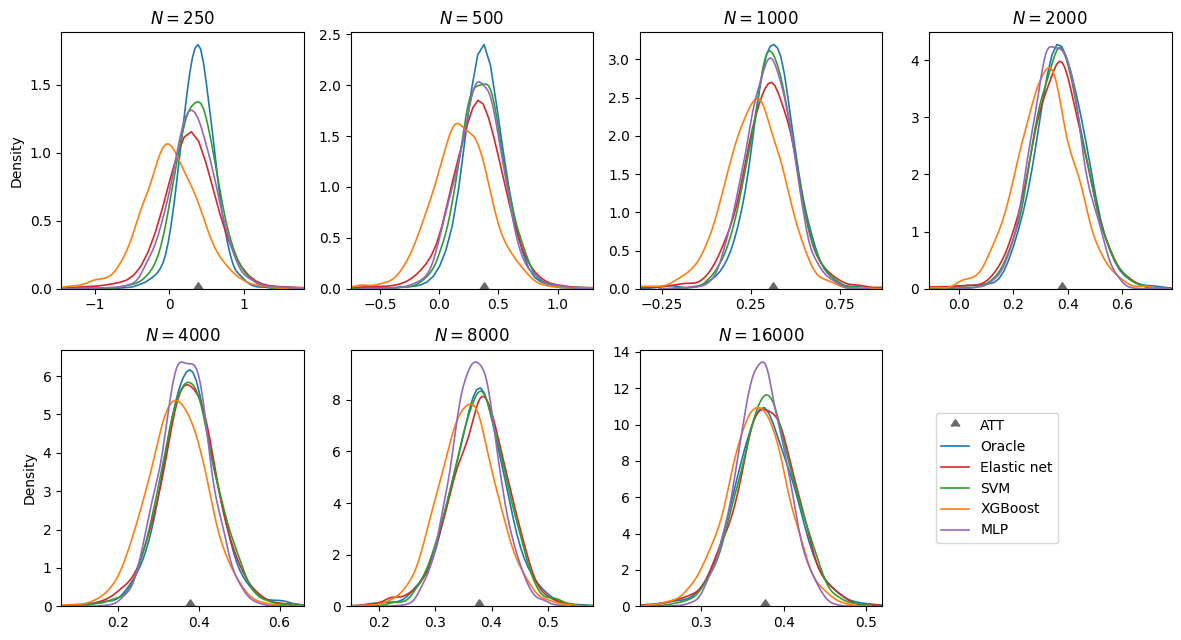

In [6]:
# Visual comparison of estimators
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6.5))

for i, N in enumerate(sample_sizes):
    ax = axes.flat[i]
    ax.scatter(theta_0, 0, marker=10, color='dimgrey', label='ATT')
    sns.kdeplot(results_att['eln'][N][0][:, 0], ax=ax, linewidth=1.2, color='tab:blue', label='Oracle')
    
    for ml_key, ml_name in ml_models.items():
        sns.kdeplot(results_att[ml_key][N][0][:, 2], ax=ax, linewidth=1.2, color=color_mapper[ml_key], label=ml_name)
    ax.set_title(r'$N=$' + f'{N}')
    
    if not (i==0 or i==4):
        ax.set_ylabel('') 
    if i==0:
        ax.set_xlim(left=-1.45, right=1.8)
        ax.set_yticks([0, 0.5, 1, 1.5])
    elif i==1:
        ax.set_xlim(left=-0.75, right=1.3)
    elif i==2:
        ax.set_xlim(left=-0.375, right=0.99)
        ax.set_xticks([-0.25, 0.25, 0.75])
    elif i==3:
        ax.set_xlim(left=-0.11, right=0.78)
        ax.set_yticks([0, 1, 2, 3, 4])
    elif i==4:
        ax.set_xlim(left=0.06, right=0.66)
    elif i==5:
        ax.set_xlim(left=0.15, right=0.58)
    else:
        ax.set_xlim(left=0.225, right=0.52)
        handles, labels = ax.get_legend_handles_labels()

axes.flat[-1].legend(handles, labels, loc='center left', bbox_to_anchor=(0, 0.5))        
axes.flat[-1].axis('off')
fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures_att/Sampling_distribution.{fmt}', dpi=300, bbox_inches='tight')

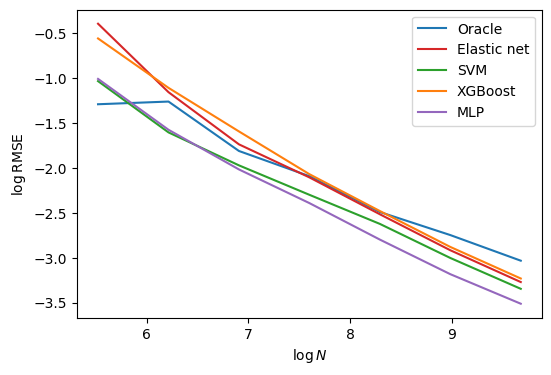

In [7]:
# Convergence rates
plt.figure(figsize=(6, 4))
rmse_list = []

rmse = [np.sqrt(np.mean((results_att['eln'][N][0][:, 0]-theta_0)**2)) for N in sample_sizes]
rmse_list.append(rmse)
plt.plot(np.log(sample_sizes), np.log(rmse), color='tab:blue', label='Oracle')

for ml_key, ml_name in ml_models.items():
    rmse = [np.sqrt(np.mean((results_att[ml_key][N][0][:, 2]-theta_0)**2)) for N in sample_sizes]
    rmse_list.append(rmse)
    plt.plot(np.log(sample_sizes), np.log(rmse), color=color_mapper[ml_key], label=ml_name)

plt.xlabel(r'$\log N$')
plt.ylabel(r'$\log$' + 'RMSE')
plt.legend()

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_att/Convergence_rates_1.{fmt}', dpi=300, bbox_inches='tight')

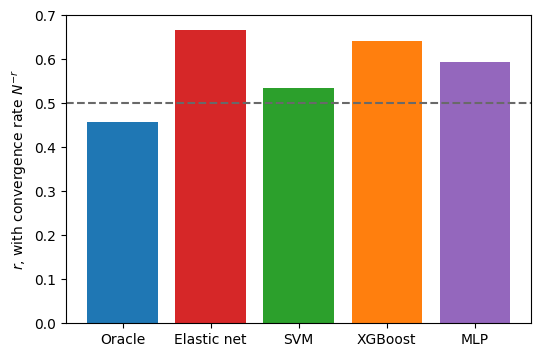

In [8]:
# Convergence rates
rmse_list = np.array(rmse_list).T
slopes = np.polyfit(np.log(sample_sizes), np.log(rmse_list), 1)[0, :]

plt.figure(figsize=(6, 4))
plt.bar(['Oracle']+list(ml_models.values()), -slopes, color=['tab:blue']+list(color_mapper.values()))
plt.axhline(y=0.5, color='dimgrey', linestyle='--')
plt.ylabel(r'$r$, with convergence rate $N^{-r}$')

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_att/Convergence_rates_2.{fmt}', dpi=300, bbox_inches='tight')

In [9]:
-slopes

array([0.45786106, 0.66668872, 0.53558734, 0.64189942, 0.59337752])

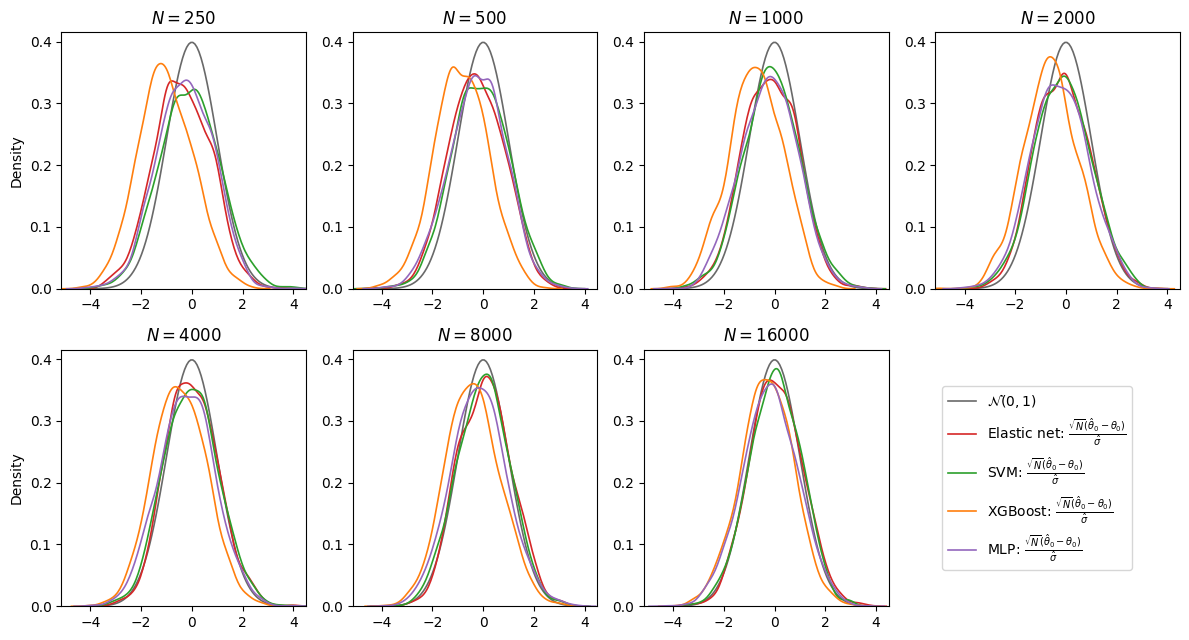

In [10]:
# Asymptotic normality
grid = np.linspace(-4, 4, 100)
pdf_values = norm.pdf(grid)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6.5))

for i, N in enumerate(sample_sizes):
    ax = axes.flat[i]
    ax.plot(grid, pdf_values, linewidth=1.2, color='dimgrey', label=r'$\mathcal{N}(0,1)$')
    
    for ml_key, ml_name in ml_models.items():
        att_estimates, sigma_estimates = results_att[ml_key][N][0][:, 2], results_att[ml_key][N][1][:, 1]
        sns.kdeplot(np.sqrt(N)*(att_estimates-theta_0)/sigma_estimates, 
                    ax=ax, linewidth=1.2, color=color_mapper[ml_key],
                    label=ml_name+r': $\frac{\sqrt{N}(\hat{\theta}_0-\theta_0)}{\hat{\sigma}}$')
        
    ax.set_xlim(left=-5.15, right=4.5)
    ax.set_ylim(bottom=None, top=0.415)
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
    ax.set_title(r'$N=$' + f'{N}')
    
    if not (i==0 or i==4):
        ax.set_ylabel('') 
    if i==6: 
        handles, labels = ax.get_legend_handles_labels()
  
axes.flat[-1].legend(handles, labels, loc='center left', bbox_to_anchor=(0, 0.5))        
axes.flat[-1].axis('off')
fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures_att/Asymptotic_normality.{fmt}', dpi=300, bbox_inches='tight')

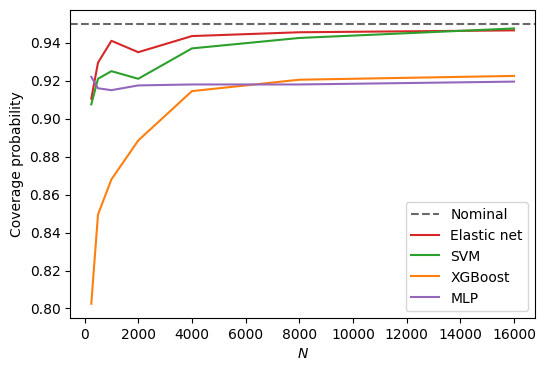

In [11]:
# Coverage probability
plt.figure(figsize=(6, 4))
plt.axhline(y=0.95, color='dimgrey', linestyle='--', label='Nominal')

for ml_key, ml_name in ml_models.items():
    CIs_list = [results_att[ml_key][N][2][:, 2:] for N in sample_sizes]
    cov_prob = [np.mean((theta_0>=CIs[:,0]) & (theta_0<=CIs[:,1])) for CIs in CIs_list]
    plt.plot(sample_sizes, cov_prob, color=color_mapper[ml_key], label=ml_name)

plt.xlabel(r'$N$')
plt.ylabel('Coverage probability')
plt.legend()

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_att/Coverage_probability.{fmt}', dpi=300, bbox_inches='tight')